In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
from src.classes.ClassFractionalSin import FractionalSin
from src.classes.ClassFractionalBiPotential import FractionalBiPotential
from src.classes.ClassFractionalQuadSin import FractionalQuadSin
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config
from configs import project_config
from tqdm import tqdm
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config

# From A ridge estimator of the drift from discrete repeated observations of the solutions of a stochastic differential equation (Denis et al 2021)

In [2]:
config = get_config()

In [3]:
def rmse_ignore_nans(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

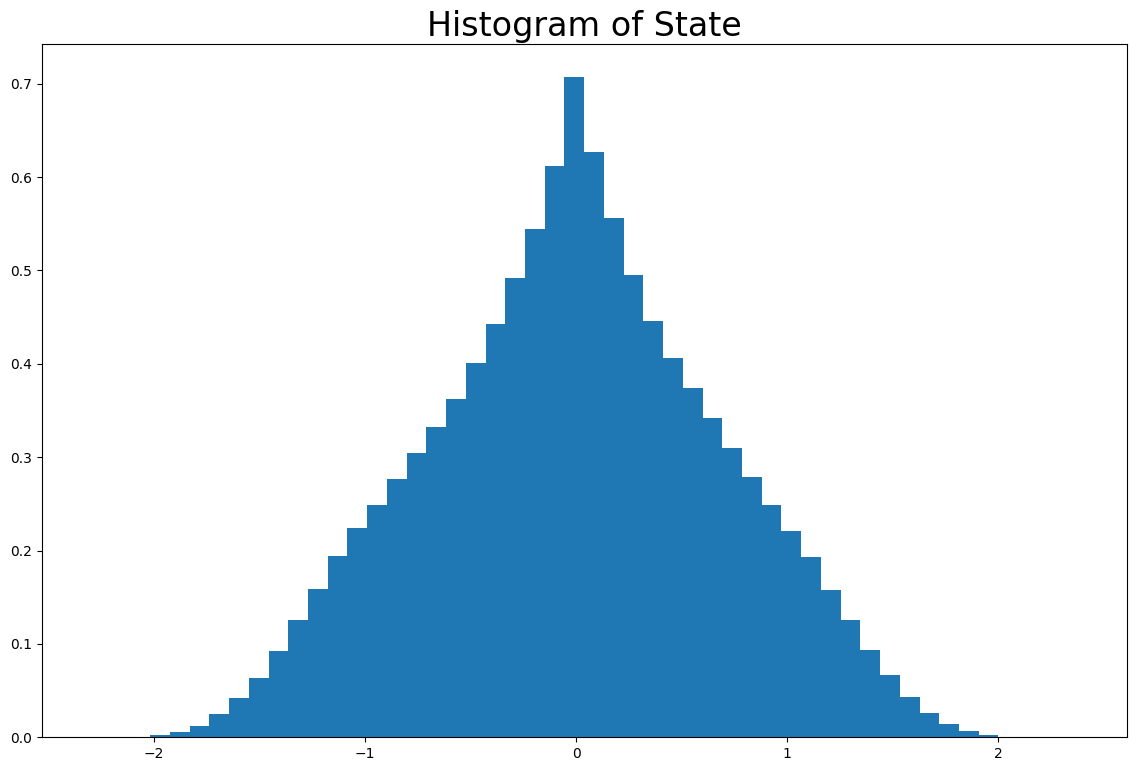

In [4]:
num_paths = 10952
num_time_steps = config.ts_length
isUnitInterval = True
diff = config.diffusion
initial_state = config.initState
rvs = None
H = config.hurst
deltaT = config.deltaT
t0 = config.t0
t1 = deltaT * num_time_steps
if "QuadSin" in config.data_path:
    fQuadSin = FractionalQuadSin(quad_coeff=config.quad_coeff, sin_coeff= config.sin_coeff, sin_space_scale=config.sin_space_scale, diff=diff, X0=initial_state)
    paths = np.array(
        [fQuadSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
        (num_paths, num_time_steps+1))
elif "fSin" in config.data_path:
    fSin = FractionalSin(mean_rev=config.mean_rev, space_scale=1, diff=diff, X0=initial_state)
    paths = np.array(
        [fSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
        (num_paths, num_time_steps+1))
elif "fBiPot" in config.data_path:
    fBiPot = FractionalBiPotential(const=config.const, quartic_coeff=config.quartic_coeff, quad_coeff = config.quad_coeff, diff=diff, X0=initial_state)
    paths = np.array(
        [fBiPot.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
        (num_paths, num_time_steps+1))

fig, ax = plt.subplots(figsize=(14,9))
plt.hist(paths.flatten(), bins=50, density=True)
plt.title("Histogram of State", fontsize=24)
plt.show()
plt.close()

In [5]:
print(np.min(paths), np.max(paths))
for k in range(num_paths, 1000):
    plt.plot(np.arange(1, 258), paths[k,:])
plt.show()

-2.297222837655056 2.373744427146897


In [6]:
def spline_basis(paths, KN, AN, BN, M):
    assert (paths.shape[0] >= 1 and len(paths.shape)==2)
    assert (AN < BN and KN > 0 and M > 0)
    def construct_ith_knot(i, AN, BN, KN):
        if i < 0:
            return AN
        elif i > KN:
            return BN
        else:
            return AN + i*(BN-AN)/KN
    def bspline(i, l, u, x, KN, M):
        if l == 0 and -M <= i <= KN+M-1:
            return ((u[i] <= x) & (x < u[i+1])).astype(float)
        elif 1 <= l <= M  and -M <= i <= KN+M-l-1:
            num1 = ((x-u[i])/(u[i+l]-u[i]))
            num1[np.isinf(num1)] = 0.
            num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
            num2[np.isinf(num2)] = 0.
            return num1*bspline(i=i,l=l-1, u=u, x=x, KN=KN, M=M)+num2*bspline(i=i+1, l=l-1, u=u, x=x, KN=KN, M=M)

    knots = {i:construct_ith_knot(i, AN, BN, KN) for i in range(-M, KN+M+1)}
    if paths.shape[1] > 1:
        paths = paths[:,:-1].flatten()
    else:
        paths = paths.flatten()
    basis = np.array([bspline(i=i, l=M, u=knots, x=paths, KN=KN,M=M) for i in range(-M, KN)]).T
    assert (basis.shape == (paths.shape[0], KN+M)), f"Basis is shape {basis.shape} but should be {(paths.shape[0], KN+M)}"
    assert np.all(basis >= 0.)
    return basis

import scipy
def find_optimal_estimator_coeffs(B, Z, KN, LN, M):
    # Precompute certain matrices
    BTB = B.T@B
    BTZ = (B.T@Z)
    const = (KN+M)*LN
    if np.all(np.linalg.eigvalsh(BTB)>0.):
        print(f"Matrix BTB is invertible\n")
        a = np.linalg.inv(BTB)@BTZ
        if a.T@a <= const:
            print(f"L2 norm of coefficients automatically satisfies projection constraint\n")
            return a
    I = np.eye(KN+M)
    def obj(l):
        inv = np.linalg.inv(BTB+l*I) @ BTZ
        return np.abs(inv.T@inv - const)
    opt = scipy.optimize.minimize(obj, max(0.,-np.min(np.linalg.eigvalsh(BTB)))+1e-12)
    lhat = np.inf
    while not (opt.success) and not np.allclose(lhat, opt.x):
        lhat = opt.x
        opt = scipy.optimize.minimize(obj, opt.x)
    lhat = opt.x[0]
    a = np.atleast_2d(np.linalg.inv(BTB+lhat*I)@BTZ)
    assert (np.allclose(a.T@a , const))
    return a

def construct_estimator(coeffs, B, LN):
    drift  = B@coeffs
    drift[np.abs(drift) > np.sqrt(LN)] = np.sqrt(LN)*np.sign(drift[np.abs(drift) > np.sqrt(LN)])
    return drift

def true_drift(prev, num_paths, config):
    assert (prev.shape == (num_paths, config.ndims))
    drift_X = -(4. * config.quartic_coeff * np.power(prev, 3) + 2. * config.quad_coeff * prev + config.const)
    return drift_X[:, np.newaxis, :]

def plot_errors(config, true_states, global_states, local_states, KN):
    true_states /= np.sqrt(config.deltaT)
    global_states/= np.sqrt(config.deltaT)
    local_states/= np.sqrt(config.deltaT)
    local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5) #/np.arange(1, local_states.shape[1]+1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(14,9))
    total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
    ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
    ax.set_title(f"Cumulative Errors for Ridge Estimator",fontsize=40)
    ax.set_ylabel("RMSE", fontsize=38)
    ax.set_xlabel("Time Axis", fontsize=38)
    ax.tick_params(labelsize=38)
    plt.tight_layout()
    save_path = f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/"
    for f in os.listdir(save_path):
        if "Ridge_DriftTrack_fBiPot_" in f:
            os.remove(save_path + f)
    plt.savefig(save_path + f"Ridge_DriftTrack_fBiPot_{KN}KN.png",  bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Final time cumulative local-time error {total_local_errors[-1]} at KN {KN}\n")

In [7]:
config.data_path

'/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fBiPot_samples_t00_dT3906e-03_T256_025a_-05b_00c_10Diff_00Init.npy'

In [8]:
if "fQuadSin" in config.data_path:
    AN = np.min(paths)-0.5
elif "fBiPot" in config.data_path:
    AN = np.min(paths)-0.5
BN = -AN
M = 3
LN = np.log(num_paths)
AN

-2.797222837655056

In [9]:
num_time_steps = 100
num_state_paths = 100
rmse_quantile_nums = 20
KNS = [2,3,4,5,6,7,8,9,10,20,25,30, 35, 40, 45]

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))


Matrix BTB is invertible



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:01<00:00, 12.06it/s]


0.015999056628349773 (0.014356483567216041, 0.020022191782764254) inf


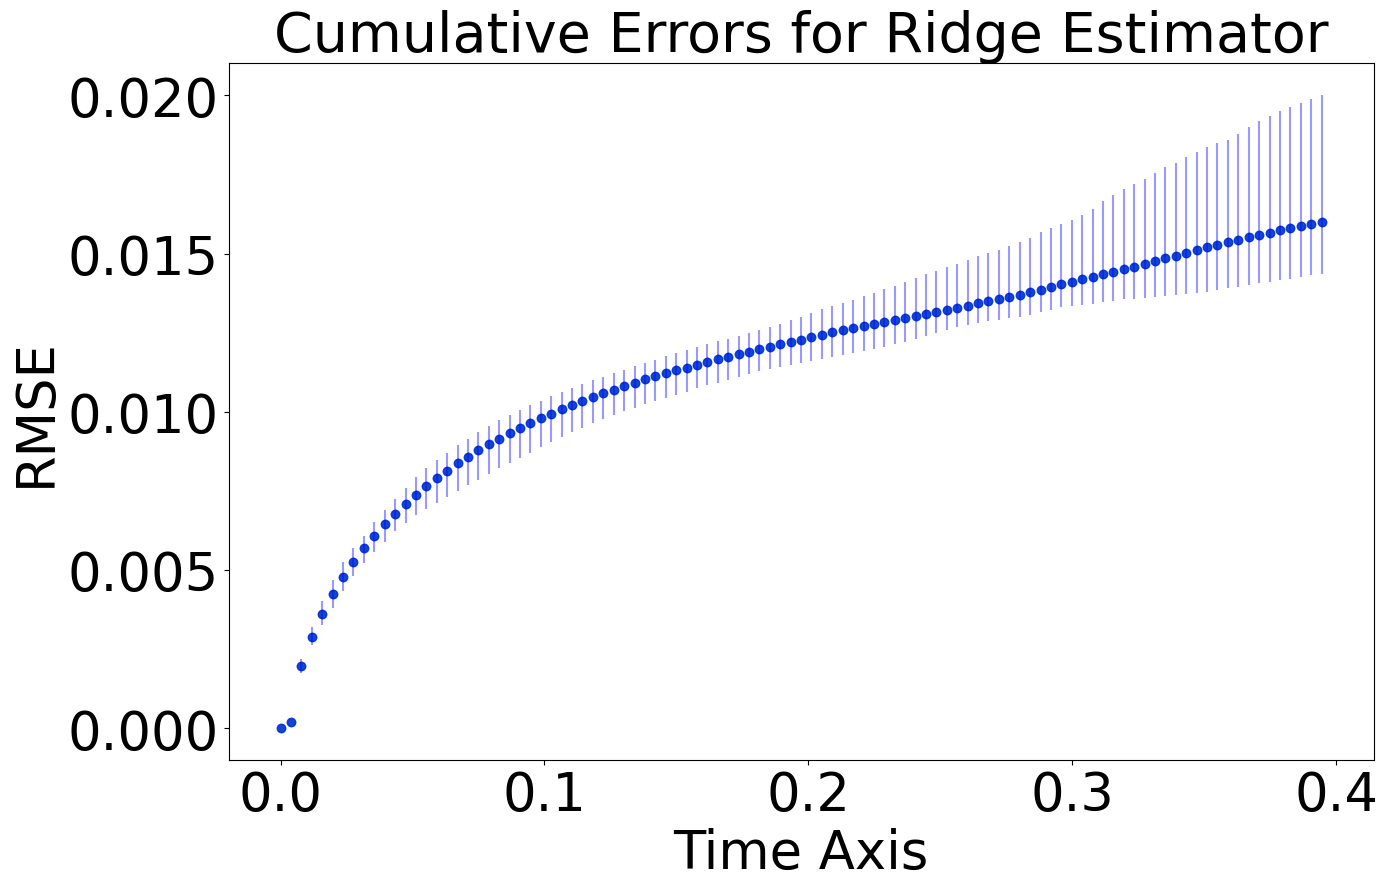

Final time cumulative RMSE local-time error 0.015999056628349773 with IQR (0.014356483567216041, 0.020022191782764254) at KN 2

Matrix BTB is invertible



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:01<00:00, 11.76it/s]


0.005560519952040309 (0.004188729246847838, 0.008111761596615157) 0.015999056628349773


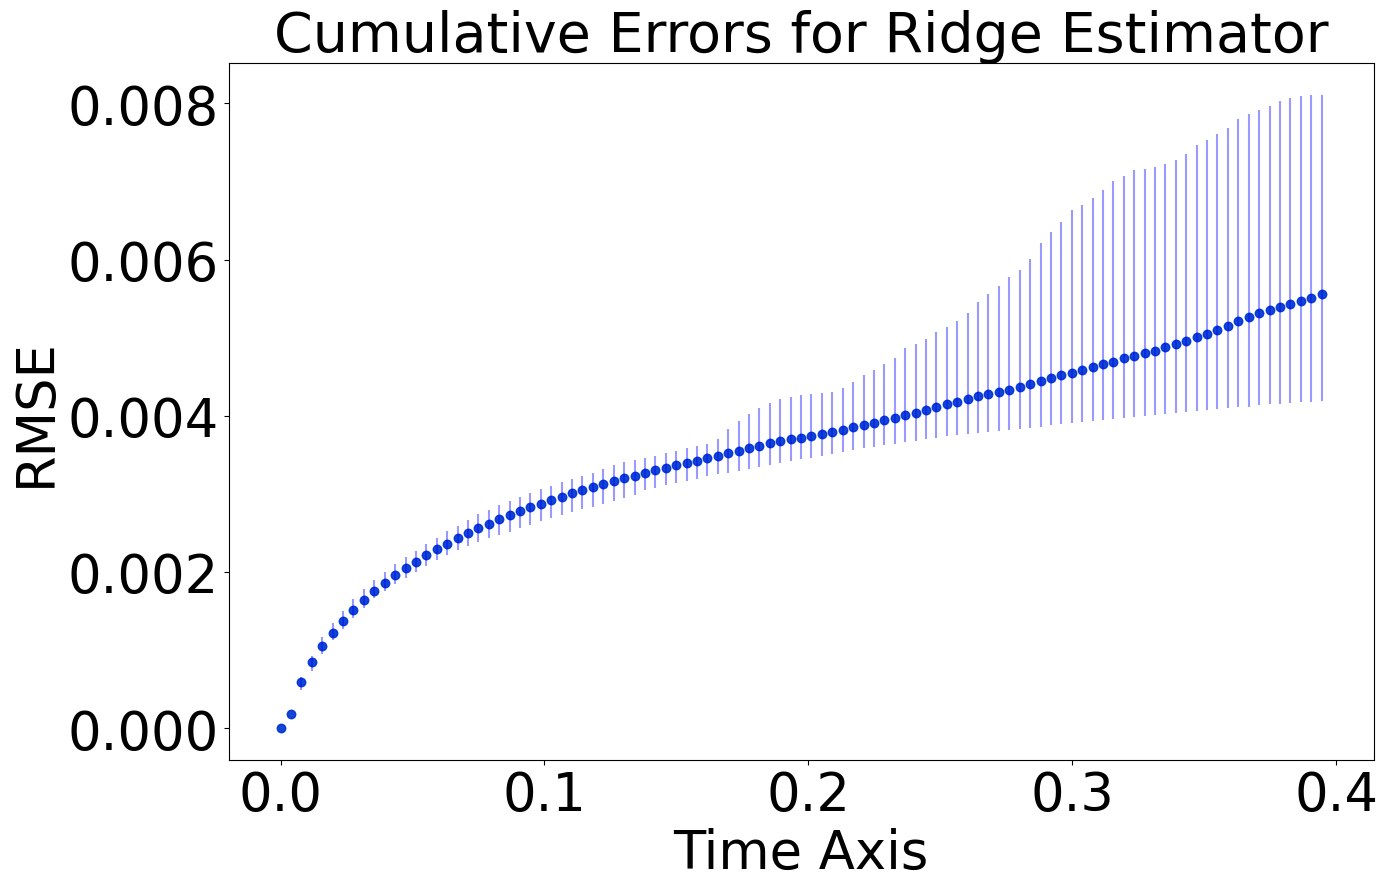

Final time cumulative RMSE local-time error 0.005560519952040309 with IQR (0.004188729246847838, 0.008111761596615157) at KN 3

Matrix BTB is invertible



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


0.006790912938930339 (0.006114080244972986, 0.008992023949150873) 0.005560519952040309
Matrix BTB is invertible



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:01<00:00, 10.70it/s]


0.0043667603109880685 (0.0028262594208543607, 0.009634649009868672) 0.005560519952040309


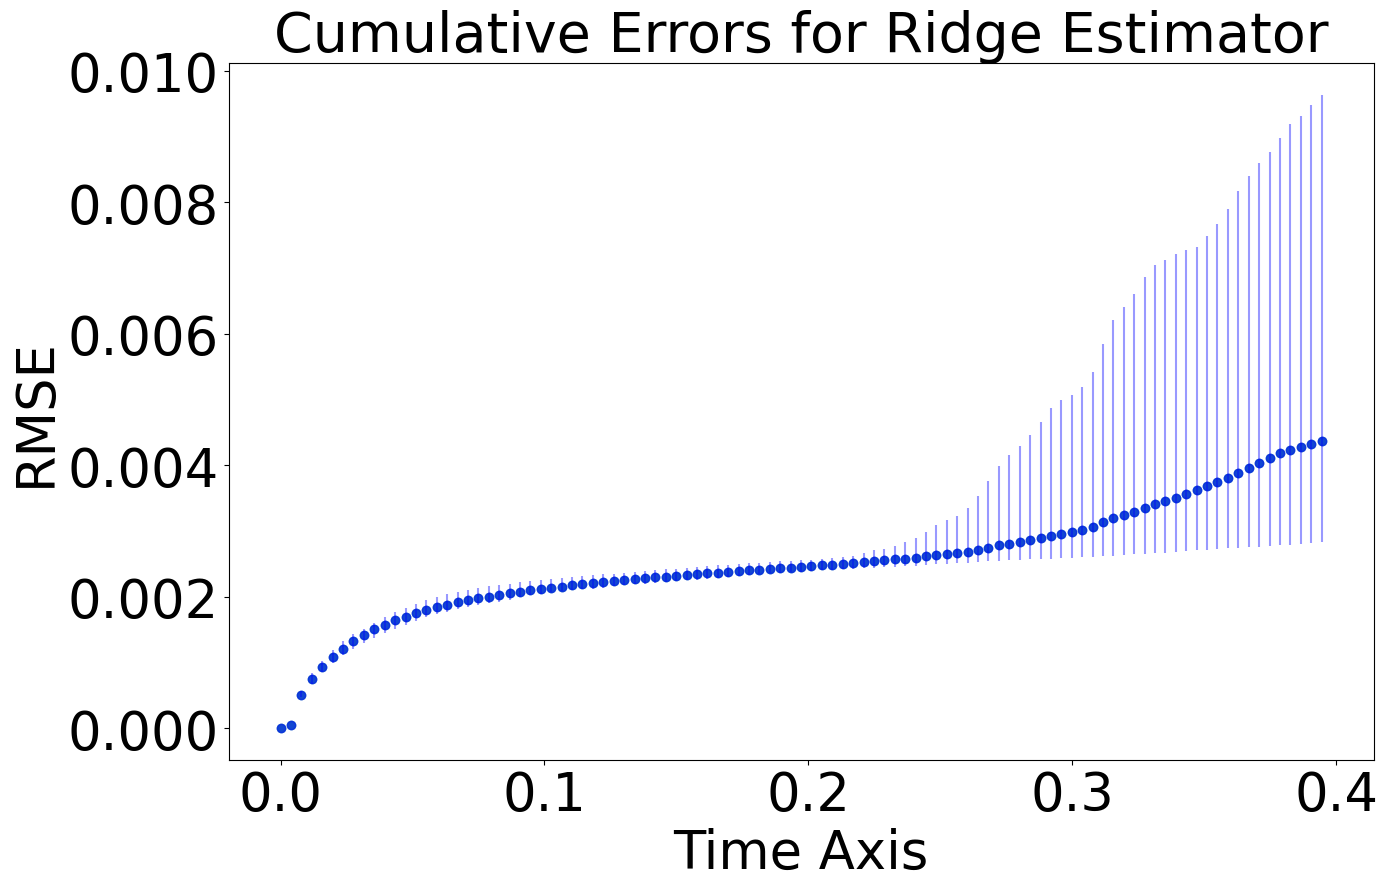

Final time cumulative RMSE local-time error 0.0043667603109880685 with IQR (0.0028262594208543607, 0.009634649009868672) at KN 5

Matrix BTB is invertible



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:02<00:00,  6.84it/s]


0.0018804159073197604 (0.0016129671441507054, 0.002370226702779843) 0.0043667603109880685


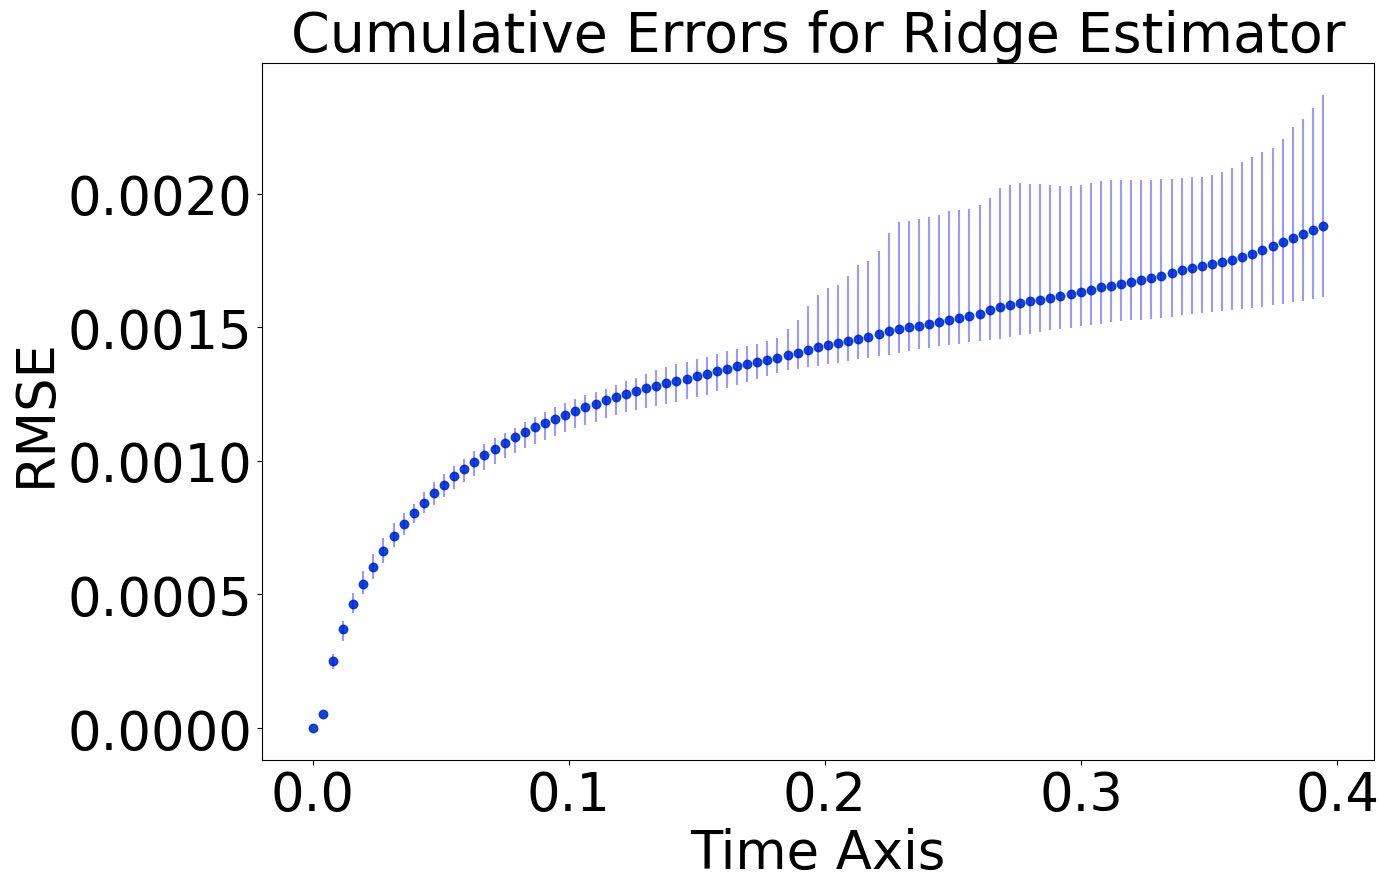

Final time cumulative RMSE local-time error 0.0018804159073197604 with IQR (0.0016129671441507054, 0.002370226702779843) at KN 6

Matrix BTB is invertible



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


0.0009827099749160093 (0.0007554031120672442, 0.0019324496031445232) 0.0018804159073197604


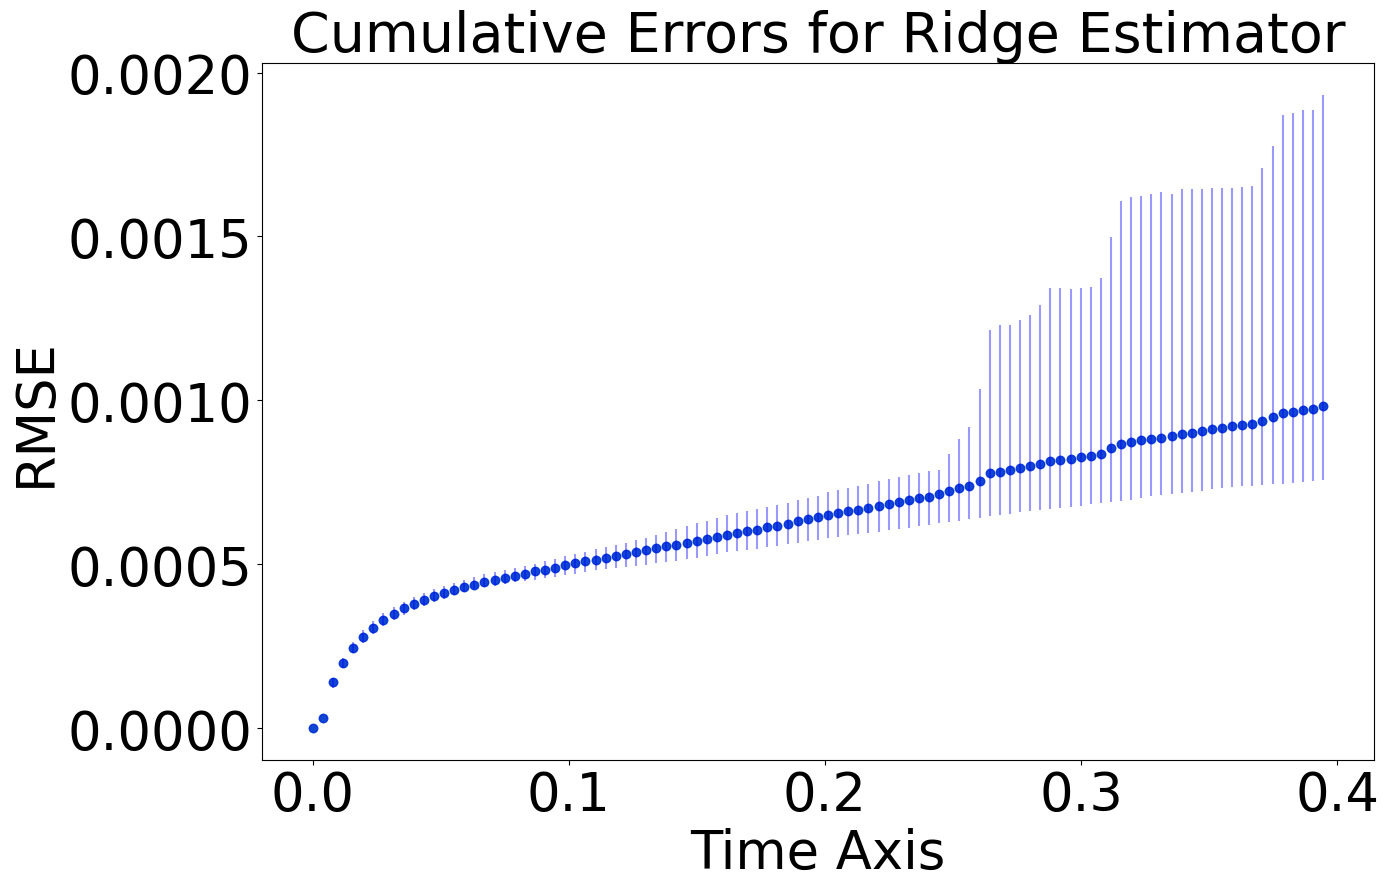

Final time cumulative RMSE local-time error 0.0009827099749160093 with IQR (0.0007554031120672442, 0.0019324496031445232) at KN 7

Matrix BTB is invertible



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:02<00:00,  6.81it/s]


0.0014826242796655144 (0.0004832615990442631, 0.007059393911574333) 0.0009827099749160093
Matrix BTB is invertible



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


0.00108166889979051 (0.0004731472684405819, 0.004655718623561721) 0.0009827099749160093
Matrix BTB is invertible



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:02<00:00,  7.00it/s]


0.000884541745474883 (0.0005130943278345537, 0.002507267360497104) 0.0009827099749160093


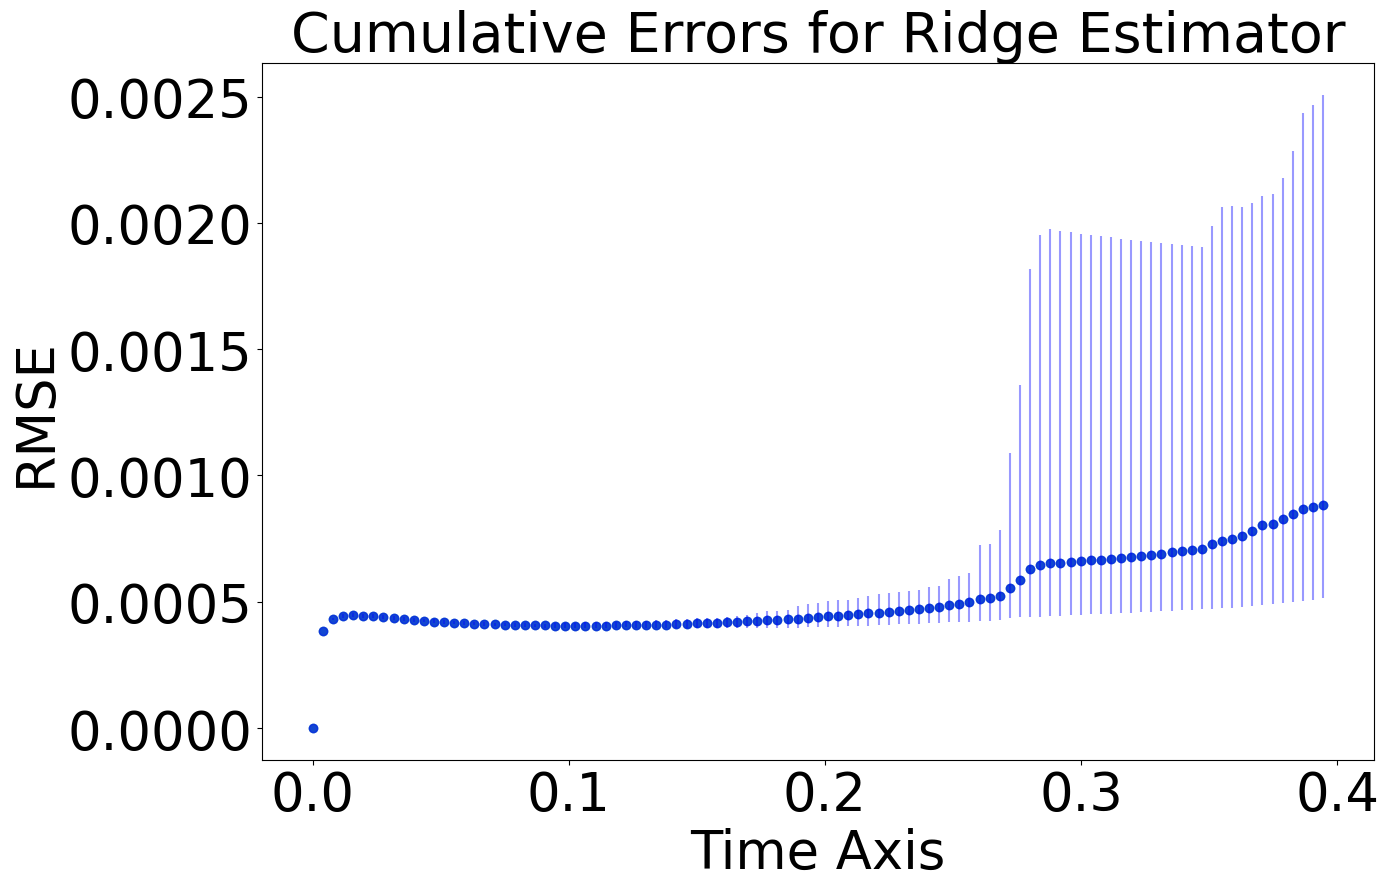

Final time cumulative RMSE local-time error 0.000884541745474883 with IQR (0.0005130943278345537, 0.002507267360497104) at KN 10



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


0.0013790499966854293 (0.0010426425199704195, 0.0026880058067786537) 0.000884541745474883


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


0.0015621780271950782 (0.0012527731423954765, 0.0024966073654150035) 0.000884541745474883


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


0.0018581980893013037 (0.0013950915215458382, 0.0037313872231890203) 0.000884541745474883


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


0.0019759853490886005 (0.0015377315444041275, 0.0033999564890430005) 0.000884541745474883


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


0.0022039591388453086 (0.0016299811830665877, 0.003941211094324267) 0.000884541745474883


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86774/1142795481.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:14<00:00,  1.43it/s]

0.002252538178973403 (0.0017803448650269716, 0.0038723196738852557) 0.000884541745474883


In [10]:
best_rmse = np.inf
toSave = True
for k_idx in range(len(KNS)):
    KN = KNS[k_idx]
    all_true_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    # all_global_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    all_local_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    assert (all_true_states.shape == all_local_states.shape)
    # assert (all_global_states.shape == all_local_states.shape)
    B = spline_basis(paths=paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
    Z = np.power(deltaT,-1)*np.diff(paths[:num_paths,:], axis=1).reshape((paths[:num_paths,:].shape[0]*(paths.shape[1]-1),1))
    assert (B.shape[0] == Z.shape[0] and len(B.shape)==len(Z.shape) == 2)
    coeffs = find_optimal_estimator_coeffs(B=B, Z=Z, KN=KN, LN=LN, M=M)
    for quant_idx in tqdm(range(rmse_quantile_nums)):
        true_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        global_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        local_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        # Initialise the "true paths"
        true_states[:, [0], :] = config.initState
        # global_states[:, [0], :] = config.initState
        local_states[:, [0], :] = config.initState

        for i in (range(1, num_time_steps + 1)):
            eps = np.random.randn(num_state_paths, 1, config.ndims) * np.sqrt(deltaT)
            assert (eps.shape == (num_state_paths, 1, config.ndims))
            true_mean = true_drift(true_states[:, i - 1, :], num_paths=num_state_paths, config=config)
            # global_basis = spline_basis(paths=global_states[:, i - 1, :], KN=KN, AN=AN, BN=BN, M=M)
            # global_mean = construct_estimator(coeffs=coeffs, B=global_basis, LN=LN)[:, np.newaxis, :]
            local_basis = spline_basis(paths=true_states[:, i - 1, :], KN=KN, AN=AN, BN=BN, M=M)
            local_mean = construct_estimator(coeffs=coeffs, B=local_basis, LN=LN)[:, np.newaxis, :]
            true_states[:, [i], :] = true_states[:, [i - 1], :] + true_mean * deltaT + eps
            # global_states[:, [i], :] = global_states[:, [i - 1], :] + global_mean * deltaT + eps
            local_states[:, [i], :] = true_states[:, [i - 1], :] + local_mean * deltaT + eps
        all_true_states[quant_idx, :, :, :] = true_states
        all_local_states[quant_idx, :, :, :] = local_states
    all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2)/config.deltaT, axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
    total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
    total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
    total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
    print(total_local_errors[-1], (total_local_errors_minq[-1], total_local_errors_maxq[-1]), best_rmse)
    if total_local_errors[-1]  < best_rmse:
        time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
        best_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
        fig, ax = plt.subplots(figsize=(14,9))
        ax.scatter(time_steps, total_local_errors)
        plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)
        ax.set_title(f"Cumulative Errors for Ridge Estimator",fontsize=40)
        ax.set_ylabel("RMSE", fontsize=38)
        ax.set_xlabel("Time Axis", fontsize=38)
        ax.tick_params(labelsize=38)
        plt.tight_layout()
        if toSave:
            save_path = f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/"
            for f in os.listdir(save_path):
                if "Ridge_DriftTrack_fBiPot_" in f:
                    os.remove(save_path + f)
            plt.savefig(save_path + (f"Ridge_DriftTrack_fBiPot_{KN}KN.png").replace(".", ""),  bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at KN {KN}\n")
